In [11]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras import layers
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer
import math
import utils
from collections import deque
import random
import seaborn as sns
import utils_adv
from sklearn import preprocessing
from keras.layers import Dense, Dropout, LSTM, GRU, BatchNormalization
from keras.callbacks import TensorBoard
from keras.callbacks import ModelCheckpoint
import time

sns.set_theme()
sns.set_style("whitegrid", {'grid.linestyle': '--'})
seq_col_brew = sns.color_palette("flag_r", 4)
sns.set_palette(seq_col_brew)
plt.rcParams["figure.figsize"] = (7,5)
plt.rcParams["axes.titlesize"] = 15
plt.rcParams['savefig.dpi'] = 1200

tf.keras.utils.set_random_seed(2) # relu

#settings
%reload_ext autoreload
%autoreload 3
%config InteractiveShell.ast_node_interactivity = 'all'
%config InlineBackend.figure_format = 'retina'

In [12]:
SEQ_LEN = 60 
FUTURE_PERIOD_PREDICT = 1  
ASSET_TO_PREDICT = 'rx1'          # --VAR CHANGE 

In [13]:
# Read in and preprocess data
# CREDIT DATA
credit_df = pd.DataFrame() # begin empty
rx1, ty1, ik1, oe1, du1 = utils.credit_data_reader()
credit_df['rx1'] = rx1['RX1 Comdty']
# credit_df['ty1'] = ty1['TY1 Comdty']
# credit_df['ik1'] = ik1['IK1 Comdty']
# credit_df['oe1'] = oe1['OE1 Comdty']
# credit_df['du1'] = du1['DU1 Comdty']

# CRYPTO DATA
ratios = ["BTC-USD", "LTC-USD", "BCH-USD", "ETH-USD"] 
crypto_df = utils_adv.crypto_data_reader(ratios)

# set the dataset                           --VAR CHANGE
dataset_df = credit_df 

dataset_df[f't+1'] = dataset_df[f'{ASSET_TO_PREDICT}'].shift(-FUTURE_PERIOD_PREDICT)
dataset_df['target'] = list(map(utils_adv.classify, dataset_df[f'{ASSET_TO_PREDICT}'], dataset_df['t+1']))

train_df, validation_df = utils_adv.split(dataset_df)

train_x, train_y = utils_adv.preprocess_df(train_df, SEQ_LEN)
validation_x, validation_y = utils_adv.preprocess_df(validation_df, SEQ_LEN)

In [14]:
my_time = time.strftime('%m.%d.%H%M', time.localtime(int(time.time())))
print(my_time)
EPOCHS = 20
BATCH_SIZE = 16
NAME = f'{my_time}-{ASSET_TO_PREDICT}-{SEQ_LEN}-{FUTURE_PERIOD_PREDICT}'  # a name for the model

12.23.2243


In [15]:
model = utils_adv.create_model(train_x)

In [16]:
checkpoint_filepath = f'models/{NAME}-checkpoint-' + '-{epoch:02d}-{val_accuracy:.3f}.hdf5'
checkpoint = ModelCheckpoint(
    filepath=checkpoint_filepath, 
    monitor='val_accuracy', 
    verbose=1, 
    save_best_only=True, 
    mode='max')

In [17]:
# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(validation_x, validation_y),
    callbacks=[checkpoint],
)


Epoch 1/20
278/278 [==============================] - ETA: 0s - loss: 0.8978 - accuracy: 0.4896
Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to models/12.23.2243-rx1-60-1-checkpoint--01-0.500.hdf5
278/278 [==============================] - 45s 142ms/step - loss: 0.8978 - accuracy: 0.4896 - val_loss: 0.7023 - val_accuracy: 0.5000
Epoch 2/20
278/278 [==============================] - ETA: 0s - loss: 0.7636 - accuracy: 0.4887
Epoch 2: val_accuracy did not improve from 0.50000
278/278 [==============================] - 38s 138ms/step - loss: 0.7636 - accuracy: 0.4887 - val_loss: 0.6934 - val_accuracy: 0.4951
Epoch 3/20
278/278 [==============================] - ETA: 0s - loss: 0.7236 - accuracy: 0.4968
Epoch 3: val_accuracy did not improve from 0.50000
278/278 [==============================] - 37s 133ms/step - loss: 0.7236 - accuracy: 0.4968 - val_loss: 0.6961 - val_accuracy: 0.5000
Epoch 4/20
278/278 [==============================] - ETA: 0s - loss: 0.7096 - accurac

In [18]:
loss, acc = model.evaluate(validation_x, validation_y, verbose=0)
print("Model, test loss: {:5.2f}".format(loss))
print("Model, test accuracy: {:5.2f}%".format(100 * acc))

print(format(NAME))
model.save(f"models/{NAME}.hdf5")
if hasattr(history, 'history'):
    np.save(f'history/{NAME}.npy',history.history)
    print("Saved history") #should happen at first run of this block after model.fit ran

Model, test loss:  0.69
Model, test accuracy: 50.00%
12.23.2243-rx1-60-1
Saved history


In [19]:
# load back history data
model_load = keras.models.load_model(f'models/{NAME}.hdf5')
history_load = np.load(f'history/{NAME}.npy',allow_pickle='TRUE').item()

loss, acc = model_load.evaluate(validation_x, validation_y, verbose=0)
print("Restored model, test loss: {:5.2f}".format(loss))
print("Restored model, test accuracy: {:5.2f}%".format(100 * acc))

Restored model, test loss:  0.69
Restored model, test accuracy: 50.00%


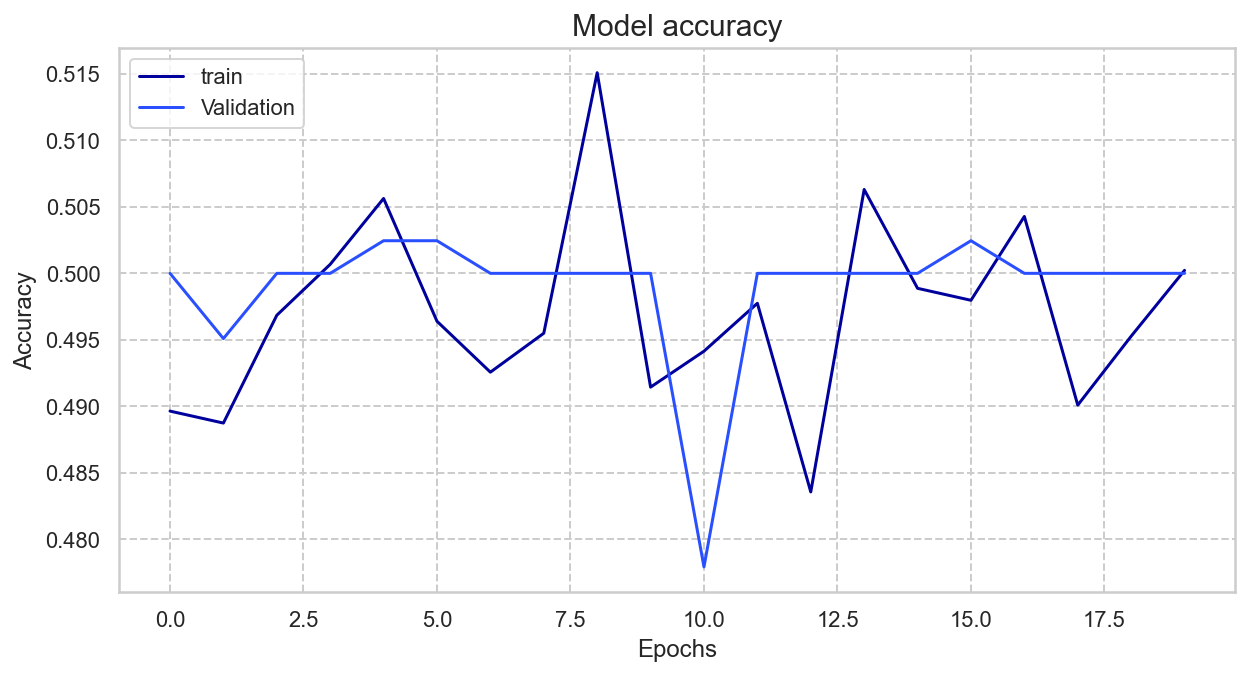

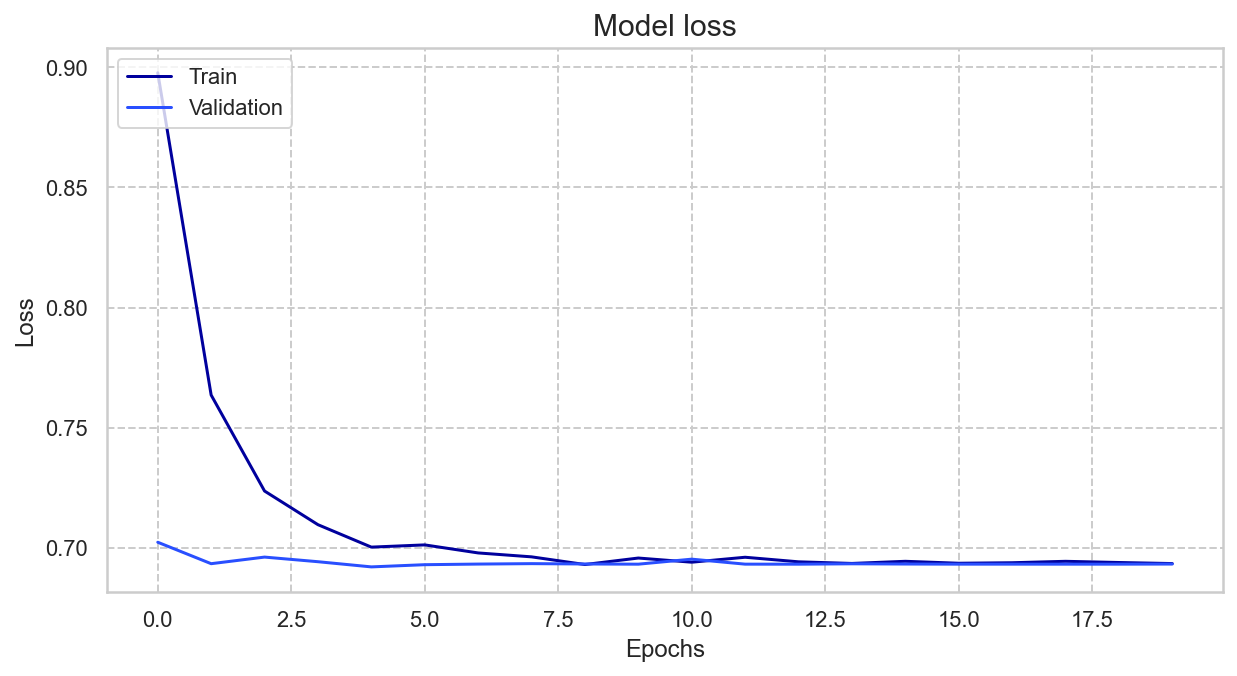

In [20]:
fig1, axs1, fig2, axs2 = utils_adv.plot_history_data(history_load)